# **Set Up**

In [40]:
# General Import
import os
import cv2
import keras
import numpy as np
import tensorflow as tf

# Data Loading
import pandas as pd
import tensorflow as tf
import tensorflow.data as tfd
import tensorflow.image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Pre Trained Models
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.applications import ResNet152, ResNet152V2
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB5

# Outputs
from IPython.display import clear_output as cls

# Plotly Configuration
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [41]:
# Set constants
train_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
test_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/test.csv"
main_dir = "/kaggle/input/ai-vs-human-generated-dataset"
history_df_path = "/kaggle/input/ai-vs-human/tensorflow2/default/1/history_df.csv"

In [42]:
# Ensure reproducibility
seed = 42
tf.random.set_seed(seed)

# **Data Exploration**

In [43]:
# Read Training & Test CSV File
train_csv = pd.read_csv(train_csv_path, index_col=0)
test_csv = pd.read_csv(test_csv_path, index_col=0)

# Quick Look
train_csv.head()

,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [44]:
# Testing CSV Quick look
test_csv.head()

""
id
test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [45]:
# Size of training and testing data
print(f"Number of training samples: {train_csv.shape[0]}")
print(f"Number of testing samples : {test_csv.shape[0]}")

Number of training samples: 79950
Number of testing samples : 5540


In [48]:
# Compute Class Distribution
class_dis = train_csv.label.value_counts().reset_index()

# Visualization
pie_fig = px.pie(
    class_dis,
    names='label',
    values='count',
    title='Class Distribution',
    hole=0.2,
)
pie_fig.show()

bar_fig = px.bar(
    class_dis,
    x='label',
    y='count',
    title='Class Distribution',
    text='count'
)
bar_fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Frequency Count'
)
bar_fig.show()

# **Data Loading**

In [9]:
for i in range(10):
    shape = plt.imread(f'{main_dir}/{train_csv.file_name[i]}').shape
    print(f"Shape of the Image: {shape}")

Shape of the Image: (768, 512, 3)
Shape of the Image: (768, 512, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (768, 512, 3)
Shape of the Image: (768, 512, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (528, 768, 3)
Shape of the Image: (528, 768, 3)


In [10]:
# Collect Training image paths
image_paths, image_labels = train_csv.file_name, train_csv.label

In [11]:
# Define split sizes (80% train, 10% val, 10% test)
total_size = len(image_paths)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = int(0.1 * total_size)

print(f"Training Data   : {train_size}")
print(f"Testing Data    : {test_size}")
print(f"Validation Data : {val_size}")

Training Data   : 63960
Testing Data    : 7995
Validation Data : 7995


In [12]:
train_paths, train_labels = image_paths[:train_size], image_labels[:train_size]
val_paths, val_labels = image_paths[train_size:train_size+val_size], image_labels[train_size:train_size+val_size]
test_paths, test_labels = image_paths[train_size+val_size:], image_labels[train_size+val_size:]

In [13]:
BATCH_SIZE = 32

# Updated generator function that works for train, val, and test sets
def image_generator(file_paths, labels):
    for file_path, label in zip(file_paths, labels):
        file_path = main_dir + '/' + file_path
        image = cv2.imread(file_path)  # Read using OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = cv2.resize(image, (512, 512))  # Resize
        image = image.astype(np.float32) / 255.0  # Normalize
        yield image, label  # Yield image and label

# Function to create datasets
def create_dataset(file_paths, labels, batch_size=BATCH_SIZE):
    return tf.data.Dataset.from_generator(
        lambda: image_generator(file_paths, labels),
        output_signature=(
            tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Creating train, validation, and test datasets
train_ds = create_dataset(train_paths, train_labels)
val_ds = create_dataset(val_paths, val_labels)
test_ds = create_dataset(test_paths, test_labels)


# **Data Visualization**

In [14]:
def show_images(data, n_rows=3, n_cols=5, figsize=(15, 10)):
    # Get the images and labels
    images, labels = next(iter(data))

    # Create subplots
    plt.figure(figsize=figsize)
    n_image = 0  # Initialize the image index

    # Loop through the grid and plot images
    for i in range(n_rows):
        for j in range(n_cols):
            if n_image < len(images):  # Ensure we don't index beyond the number of images
                plt.subplot(n_rows, n_cols, n_image + 1)
                plt.imshow(images[n_image])  # Display the image
                plt.axis('off')
                plt.title("AI" if labels[n_image].numpy()==1.0 else "Human")  # Convert label to string for display
                n_image += 1

    plt.show()

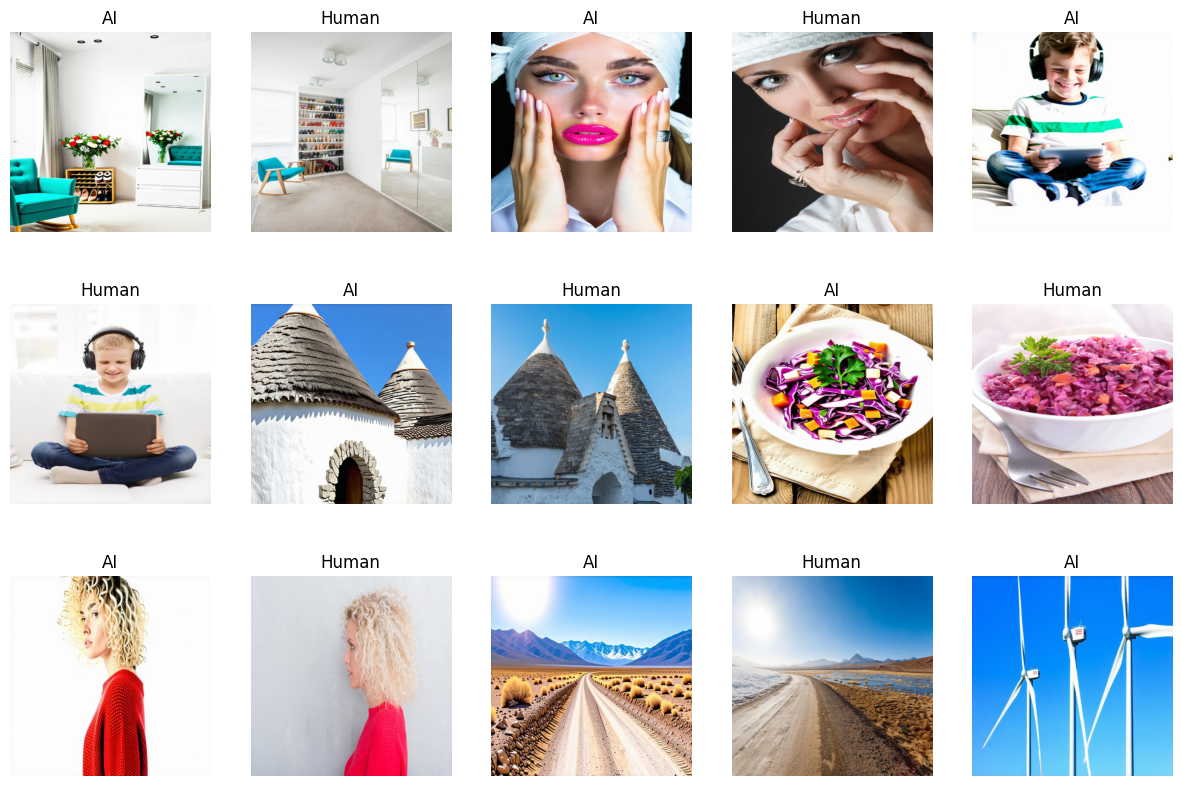

In [15]:
# Visualize Images
show_images(val_ds)

# **Pre Trained Models**

Number of training samples: 79950
Training samples: 63960
Validation samples: 7995
Test samples: 7995


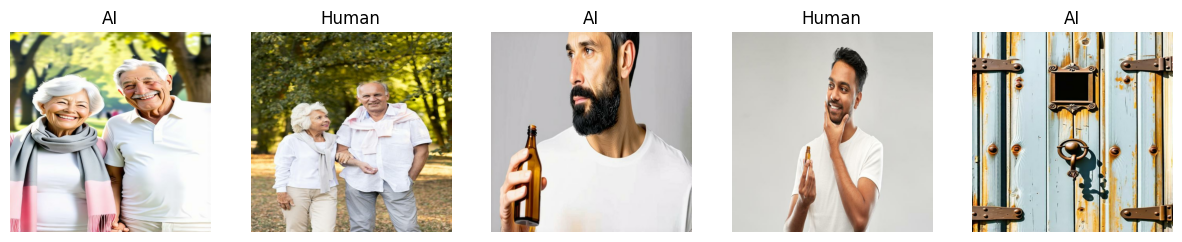

Epoch 1/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 421s 205ms/step - accuracy: 0.7877 - loss: 0.4640 - val_accuracy: 0.8273 - val_loss: 0.3933
Epoch 2/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 398s 199ms/step - accuracy: 0.8205 - loss: 0.4099 - val_accuracy: 0.8125 - val_loss: 0.4120
Epoch 3/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 398s 199ms/step - accuracy: 0.8261 - loss: 0.3982 - val_accuracy: 0.8263 - val_loss: 0.3919
Epoch 4/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 398s 199ms/step - accuracy: 0.8296 - loss: 0.3929 - val_accuracy: 0.8366 - val_loss: 0.3733
Epoch 5/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 398s 199ms/step - accuracy: 0.8310 - loss: 0.3873 - val_accuracy: 0.8402 - val_loss: 0.3685
Epoch 6/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 398s 199ms/step - accuracy: 0.8352 - loss: 0.3821 - val_accuracy: 0.8420 - val_loss: 0.3628
Epoch 7/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 398s 199ms/step - accuracy: 0.8352 - loss: 0.3797 - val_accuracy: 0.8373 - val_loss: 0.3645
Epoch 8/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 397s 199ms/step - ac

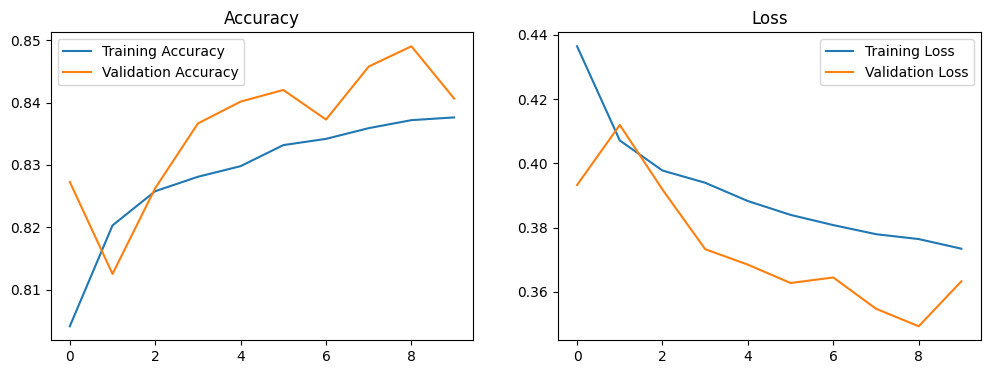

250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - accuracy: 0.8416 - loss: 0.3569

Test Accuracy: 0.8370
Test Loss: 0.3638


In [49]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Set constants
train_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
main_dir = "/kaggle/input/ai-vs-human-generated-dataset"
BATCH_SIZE = 32
IMG_SIZE = (512, 512)

# Set random seed for reproducibility
tf.random.set_seed(42)

# Load the training data
train_csv = pd.read_csv(train_csv_path, index_col=0)
print(f"Number of training samples: {train_csv.shape[0]}")

# Split data into train, validation, and test sets
total_size = len(train_csv)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)

train_df = train_csv[:train_size]
val_df = train_csv[train_size:train_size+val_size]
test_df = train_csv[train_size+val_size:]

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Create TensorFlow datasets
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(main_dir + '/' + file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize to [0,1]
    return image, label

def create_dataset(df):
    file_paths = df['file_name'].values
    labels = df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)

# Visualize some samples
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    for images, labels in dataset.take(1):
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(images[i])
            plt.title("AI" if labels[i].numpy() == 1 else "Human")
            plt.axis('off')
    plt.show()

show_samples(train_ds)

# Create ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

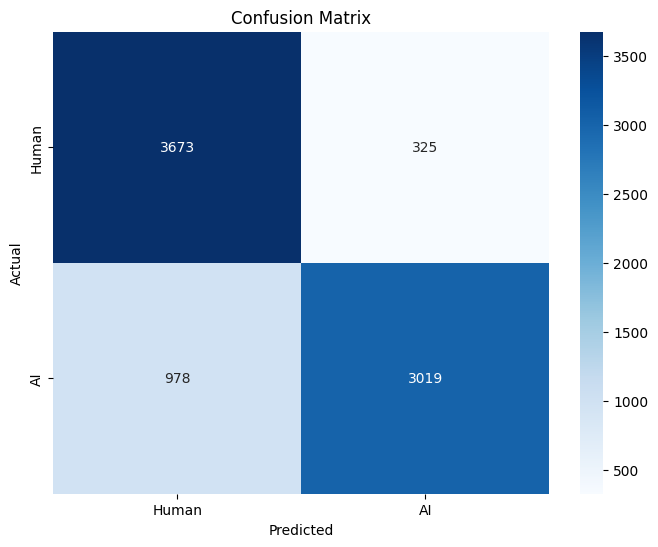


Classification Report:
              precision    recall  f1-score   support

       Human       0.79      0.92      0.85      3998
          AI       0.90      0.76      0.82      3997

    accuracy                           0.84      7995
   macro avg       0.85      0.84      0.84      7995
weighted avg       0.85      0.84      0.84      7995



In [50]:
# Additional imports needed
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle
import argparse
from PIL import Image
import numpy as np

# 1. Plot Confusion Matrix
def plot_confusion_matrix(model, dataset):
    # Get all predictions and true labels
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images, verbose=0)
        y_pred.extend((predictions > 0.5).astype(int).flatten())
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Human', 'AI']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Call the function with your test dataset
plot_confusion_matrix(model, test_ds)

In [52]:
# 2. Save the Model (Updated Version)
def save_model(model, model_name='ai_vs_human_resnet50'):
    # Save the entire model (as .keras file)
    model.save(f'{model_name}.keras')
    
    # Save just the weights (with correct extension)
    weights_path = f'{model_name}.weights.h5'  # Note the required extension
    model.save_weights(weights_path)
    
    print(f"Model saved as {model_name}.keras")
    print(f"Model weights saved as {weights_path}")

save_model(model)

Model saved as ai_vs_human_resnet50.keras
Model weights saved as ai_vs_human_resnet50.weights.h5
